In [1]:
import matplotlib.pyplot as pl
import pandas as pd
import rules.enzymes_v04 as enz
enzymes = [item for item in dir(enz) if not item.startswith("__")]

pl.rcParams["font.family"] = "sans-serif"
pl.rcParams["font.size"] = 10

In [2]:
reports = ['v04_Rac1_dominant', 
           'v04_RhoA_dominant']

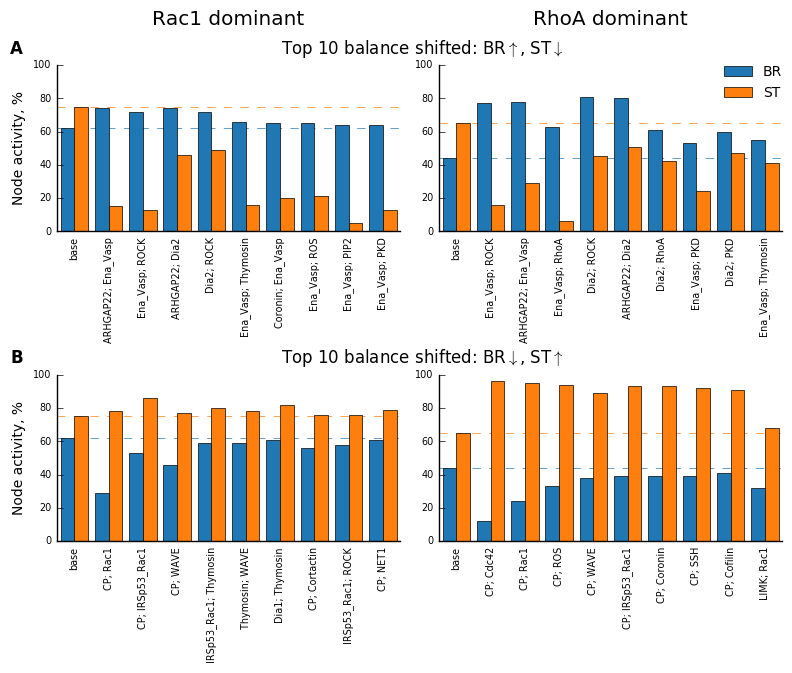

In [14]:
topX = 10
  
def prepare_datasets(report):    
    
    df = pd.read_csv('reports/{}/summary.csv'.format(report), index_col=0)        
    df = df.filter(regex='^(base|({0})_({0}))$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    df.columns = df.columns.str.replace(r'^({0})_({0})$'.format('|'.join(enzymes)), r'\g<1>; \g<2>').str.replace('WASP', 'N-WASP')
    df = df.transpose()
    
    base_BR = df['Actin_BR']['base']
    base_ST = df['Actin_ST']['base']
            
    df['Actin_BR_diff'] = df['Actin_BR'] / base_BR - 1
    df['Actin_ST_diff'] = df['Actin_ST'] / base_ST - 1
    df['both_diff'] = df['Actin_BR_diff'] + df['Actin_ST_diff']
    df['balance_shift'] = df['Actin_BR_diff'] * df['Actin_ST_diff']
    
    return [
            df[df.index == 'base'].append(
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0) & (df['Actin_BR_diff'] > 0)] \
                    .sort_values('balance_shift').head(topX)),
            df[df.index == 'base'].append(
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0) & (df['Actin_ST_diff'] > 0)] \
                    .sort_values('balance_shift').head(topX))
        ]
    
def plot_knockdowns(dataframe, ax, maxn, with_y_label):
    colors = ['#1f77b4', '#ff7f0e']
    
    dataframe = dataframe[['Actin_BR', 'Actin_ST']].rename(columns={'Actin_BR': 'BR', 'Actin_ST': 'ST'})
    
    dataframe.plot.bar(width=0.8, color=colors, 
                            ax=ax, legend=False, linewidth=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(labelsize='x-small')
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_tick_params(labelsize='x-small')

    ax.set_ylim(top=100)
    if with_y_label:
        ax.set_ylabel('Node activity, %')
    ax.set_xlim(-0.5, maxn-0.5)
    
    br, st = dataframe.loc['base']
    ax.plot([-1, 100], [br, br], linewidth=0.5, linestyle='--', color=colors[0], zorder=-1)
    ax.plot([-1, 100], [st, st], linewidth=0.5, linestyle='--', color=colors[1], zorder=-1)
    
data = {}

for report in reports:
    data[report] = prepare_datasets(report)

row_titles = [
    r"Top %d balance shifted: BR$\uparrow$, ST$\downarrow$" % topX,
    r"Top %d balance shifted: BR$\downarrow$, ST$\uparrow$" % topX
]
        
fig, axis = pl.subplots(nrows=2, ncols=2, sharey=False, figsize=(8, 7))
for row in range(2):  
    for col in range(2):
        plot_knockdowns(data[reports[col]][row], axis[row][col], topX, with_y_label=(col==0))                
        
axis[0][0].set_title("Rac1 dominant", fontsize='x-large', y=1.2)
axis[0][1].set_title("RhoA dominant", fontsize='x-large', y=1.2)

axis[0][1].legend(loc='upper right', 
              ncol=1, 
              frameon=False, borderpad=0, borderaxespad=0,
              prop={'size':10})

for row, title in enumerate(row_titles):
    axis[row][1].text(-1, 107, title, fontsize='large', ha='center', 
                      bbox=dict(facecolor='white', edgecolor='none', pad=0))
    axis[row][0].text(-1.5, 107, chr(65+row), fontsize='large', ha='right', 
                      fontweight='bold')
    
        

pl.tight_layout(h_pad=2.0)
            
pl.savefig('charts/fig_6_top_10_balance_shifted.png', bbox_inches='tight', dpi=300)
pl.savefig('charts/fig_6_top_10_balance_shifted.svg', bbox_inches='tight')
pl.savefig('charts/fig_6_top_10_balance_shifted.eps', bbox_inches='tight')

In [8]:
data['v04_Rac1_dominant'][1]

,Actin_BR,Actin_ST,Actin_BR_diff,Actin_ST_diff,both_diff,balance_shift
base,62,75,0.000000,0.000000,0.000000,0.000000
CP; Rac1,29,78,-0.532258,0.040000,-0.492258,-0.021290
CP; IRSp53_Rac1,53,86,-0.145161,0.146667,0.001505,-0.021290
CP; WAVE,46,77,-0.258065,0.026667,-0.231398,-0.006882
IRSp53_Rac1; Thymosin,59,80,-0.048387,0.066667,0.018280,-0.003226
Thymosin; WAVE,59,78,-0.048387,0.040000,-0.008387,-0.001935
Dia1; Thymosin,61,82,-0.016129,0.093333,0.077204,-0.001505
CP; Cortactin,56,76,-0.096774,0.013333,-0.083441,-0.001290
IRSp53_Rac1; ROCK,58,76,-0.064516,0.013333,-0.051183,-0.000860
CP; NET1,61,79,-0.016129,0.053333,0.037204,-0.000860
